# Neural Network Optimization and Tuning

I've learned how to build computational graphs in PyTorch and compute gradients. The final piece to training a network is applying the gradients to update the network parameters. In this tutorial I shall learn how to implement a number of optimization techniques in PyTorch along with other tuning methods. 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets, models
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable
from collections import namedtuple
from IPython.display import Image
%matplotlib inline
np.random.seed(2018)

I uses the PyTorch dataset API to load a dataset with exactly the same properties as the MNIST handwritten digits dataset. However, instead of handwritten digits, this dataset contains images of 10 different **common clothing items**, hence the name **Fashion-MNIST** . Performance on MNIST saturates quickly with simple network architectures and optimization methods. This dataset is more difficult than MNIST and is useful to demonstrate the relative improvements of different optimization methods. 

Some of the characteristics are mentioned below.

- 28x28 images
- 10 classes
- Single color channel (B&W)
- Centered objects
- 50000 training set members
- 10000 test set members


In [2]:
# Fashion Class that enables the Dataset download and basic transformations
class Fashion(datasets.MNIST):
    def __init__(self, root, train=True, transform=None, target_transform=None, download=False):
        self.urls = [
            'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz',
            'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz',
            'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz',
            'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz',
        ]
        super(Fashion, self).__init__(
            root, train=train, transform=transform, target_transform=target_transform, download=download
        ) 

def decode_label(l):
    return ["Top",
     "Trouser",
     "Pullover",
     "Dress",
     "Coat",
     "Sandal",
     "Shirt",
     "Sneaker",
     "Bag",
     "Ankle boot"
    ][l]

In [3]:
train_data = Fashion('/tmp/data', train=True, download=True, transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,))
                            ]))

test_data = Fashion('/tmp/data', train=False, download=True, transform=transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.1307,), (0.3081,))
                            ]))

100%|████████████████████████████████████████████████████████████████▉| 26402816/26421880 [00:21<00:00, 1413777.52it/s]

Extracting /tmp/data\Fashion\raw\train-images-idx3-ubyte.gz



0it [00:00, ?it/s]
 56%|████████████████████████████████████████▌                                | 16384/29515 [00:00<00:00, 88421.69it/s]
32768it [00:00, 41167.17it/s]                                                                                          

Extracting /tmp/data\Fashion\raw\train-labels-idx1-ubyte.gz



0it [00:00, ?it/s]
 93%|██████████████████████████████████████████████████████████████▌    | 4128768/4422102 [00:03<00:00, 2510202.05it/s]
4423680it [00:03, 1415424.47it/s]                                                                                      

Extracting /tmp/data\Fashion\raw\t10k-images-idx3-ubyte.gz



0it [00:00, ?it/s]
  0%|                                                                                         | 0/5148 [00:00<?, ?it/s]
8192it [00:00, 11354.19it/s]                                                                                           

Extracting /tmp/data\Fashion\raw\t10k-labels-idx1-ubyte.gz
Processing...
Done!


26427392it [00:40, 1413777.52it/s]                                                                                     

## Random examples from the Fashion-MNIST dataset

C:\Users\Abhishek Singh\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
C:\Users\Abhishek Singh\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


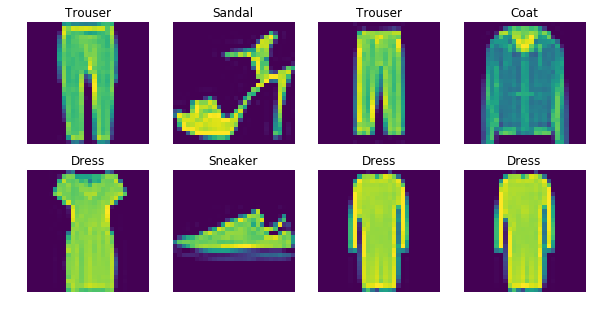

In [4]:
idxs = np.random.randint(100, size=8)
f, a = plt.subplots(2, 4, figsize=(10, 5))
for i in range(8):
    X = train_data.train_data[idxs[i]]
    Y = train_data.train_labels[idxs[i]]
    r, c = i // 4, i % 4
    a[r][c].set_title(decode_label(Y))
    a[r][c].axis('off')
    a[r][c].imshow(X.numpy())
plt.draw()

## Build a model

As I am more focussed on evaluating how the different optimization methods perform, I shall be constructing a very simple feedforward network.

In [5]:
class FashionModel(nn.Module):
    def __init__(self):
        super(FashionModel, self).__init__()
        self.fc1 = nn.Linear(784, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x))
        return x
print(FashionModel())

FashionModel(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)


## A Simple Optimizer in PyTorch

The most simple optimization method is to update the network parameters by adding the negative of the gradient scaled by a fixed learning rate $\eta$.

$$ \textbf{W'} \leftarrow \textbf{W} - \eta \nabla L(\textbf{W}) $$

PyTorch provides us a very simple and expressive API for creating custom optimizers. An optimizer in PyTorch subclasses `torch.optim.Optimizer` and is required to specify two methods.

`__init__`: Must call the superclass `__init__` and provide a list of network parameters, `params`, to optimize and a dictionary of default values provided to each parameter group, `defaults`. 

`step`: Performs an update on the network parameters. 

The meat of your optimizer logic lies in the `step` method. In this method you should update your model parameters with the help of some useful internal datastructures. Let's define these to make the following code more clear.

`self.param_groups`: When you initialize an optimizer object, you are required to provide the list of parameter objects to be optimized. In the case of `FashionModel`, there are 6 parameters -- each `Linear` layer has a weight matrix parameter and a bias vector. All of these 6 parameters are considered within a single `param_group`. This `group` will be a dictionary with an entry `params` that contains an iterable of all 6 parameters, as well as entries for all `defaults`. These `defaults` are generally useful for storing small values like hyperparameters that are standard across all parameter groups. There are more advanced cases where it can come in handy to have different values for certain entities depending on the `param_group`. 

`self.state`: This maintains state for a given parameter. Essentially it maps a parameter to a dictionary of data that you want to keep track of. This is useful in cases where you want to keep state on a per-parameter basis.

**IMPORTANT**: Unlike most other use cases in PyTorch, operations on parameters and state data should be done inplace. This ensures that the updated parameters are not updated copies of the original. In the following sample implementations, you may see some unfamiliar operations. Functions like `torch.add_` and `torch.mul_` are just inplace analogues of standard PyTorch functions. See http://pytorch.org/docs/master/torch.html for further details.


## Let's write our *Trainer*

In [6]:
train_size = train_data.train_data.shape[0]
val_size, train_size = int(0.20 * train_size), int(0.80 * train_size) # 80 / 20 train-val split
test_size = test_data.test_data.shape[0]
batch_size = 100

# Add dataset to dataloader that handles batching
train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=batch_size,
                                           sampler=torch.utils.data.sampler.SubsetRandomSampler(np.arange(val_size, val_size+train_size)))
val_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=batch_size, 
                                           sampler=torch.utils.data.sampler.SubsetRandomSampler(np.arange(0, val_size)))
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Setup metric class
Metric = namedtuple('Metric', ['loss', 'train_error', 'val_error'])

In [7]:
def inference(model, loader, n_members):
    correct = 0
    for data, label in loader:
        X = Variable(data.view(-1, 784))
        Y = Variable(label)
        out = model(X)
        pred = out.data.max(1, keepdim=True)[1]
        predicted = pred.eq(Y.data.view_as(pred))
        correct += predicted.sum()
    return correct.numpy() / n_members

class Trainer():
    """ 
    A simple training cradle
    """
    
    def __init__(self, model, optimizer, load_path=None):
        self.model = model
        if load_path is not None:
            self.model = torch.load(load_path)
        self.optimizer = optimizer
            
    def save_model(self, path):
        torch.save(self.model.state_dict(), path)

    def run(self, epochs):
        print("Start Training...")
        self.metrics = []
        for e in range(n_epochs):
            epoch_loss = 0
            correct = 0
            for batch_idx, (data, label) in enumerate(train_loader):
                self.optimizer.zero_grad()
                X = Variable(data.view(-1, 784))
                Y = Variable(label)
                out = self.model(X)
                pred = out.data.max(1, keepdim=True)[1]
                predicted = pred.eq(Y.data.view_as(pred))
                correct += predicted.sum()
                loss = F.nll_loss(out, Y)
                loss.backward()
                self.optimizer.step()
                epoch_loss += loss.data[0]
            total_loss = epoch_loss.numpy()/train_size
            train_error = 1.0 - correct.numpy()/train_size
            val_error = 1.0 - inference(self.model, val_loader, val_size)
            print("epoch: {0}, loss: {1:.8f}".format(e+1, total_loss))
            self.metrics.append(Metric(loss=total_loss, 
                                  train_error=train_error,
                                  val_error=val_error))
         

In [8]:
### LET'S TRAIN ###

# A function to apply "normal" distribution on the parameters
def init_randn(m):
    if type(m) == nn.Linear:
        m.weight.data.normal_(0,1)

# We first initialize a Fashion Object and initialize the parameters "normally".
normalmodel = FashionModel()
normalmodel.apply(init_randn)

n_epochs = 8

print("SGD OPTIMIZER")
SGDOptimizer = torch.optim.SGD(normalmodel.parameters(), lr=0.01)
sgd_trainer = Trainer(normalmodel, SGDOptimizer)
sgd_trainer.run(n_epochs)
sgd_trainer.save_model('./sgd_model.pt')
print('')


print("ADAM OPTIMIZER")
normalmodel = FashionModel()
normalmodel.apply(init_randn)
AdamOptimizer = torch.optim.Adam(normalmodel.parameters(), lr=0.01)
adam_trainer = Trainer(normalmodel, AdamOptimizer)
adam_trainer.run(n_epochs)
adam_trainer.save_model('./adam_model.pt')
print('')


print("RMSPROP OPTIMIZER")
normalmodel = FashionModel()
normalmodel.apply(init_randn)
RMSPropOptimizer = torch.optim.RMSprop(normalmodel.parameters(), lr=0.01)
rms_trainer = Trainer(normalmodel, RMSPropOptimizer)
rms_trainer.run(n_epochs)
rms_trainer.save_model('./rmsprop_model.pt')
print('')


### TEST ###
model = FashionModel()
model.load_state_dict(torch.load('./sgd_model.pt'))
test_acc = inference(model, test_loader, test_size)
print("Test accuracy of model optimizer with SGD: {0:.2f}".format(test_acc * 100))

model = FashionModel()
model.load_state_dict(torch.load('./adam_model.pt'))
test_acc = inference(model, test_loader, test_size)
print("Test accuracy of model optimizer with Adam: {0:.2f}".format(test_acc * 100))

model = FashionModel()
model.load_state_dict(torch.load('./rmsprop_model.pt'))
test_acc = inference(model, test_loader, test_size)
print("Test accuracy of model optimizer with RMSProp: {0:.2f}".format(test_acc * 100))

SGD OPTIMIZER
Start Training...


/anaconda3/envs/tf3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()
/anaconda3/envs/tf3/lib/python3.6/site-packages/ipykernel_launcher.py:43: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


epoch: 1, loss: 0.12873552
epoch: 2, loss: 0.02345240
epoch: 3, loss: 0.02074262
epoch: 4, loss: 0.01942439
epoch: 5, loss: 0.01835329
epoch: 6, loss: 0.01766403
epoch: 7, loss: 0.01695254
epoch: 8, loss: 0.01645464

ADAM OPTIMIZER
Start Training...
epoch: 1, loss: 0.26999099
epoch: 2, loss: 0.01946122
epoch: 3, loss: 0.01242979
epoch: 4, loss: 0.00995855
epoch: 5, loss: 0.00878618
epoch: 6, loss: 0.00801902
epoch: 7, loss: 0.00758505
epoch: 8, loss: 0.00729035

RMSPROP OPTIMIZER
Start Training...
epoch: 1, loss: 0.22505141
epoch: 2, loss: 0.01458840
epoch: 3, loss: 0.01202629
epoch: 4, loss: 0.01174371
epoch: 5, loss: 0.01005420
epoch: 6, loss: 0.00986540
epoch: 7, loss: 0.00877988
epoch: 8, loss: 0.00779939

Test accuracy of model optimizer with SGD: 39.85
Test accuracy of model optimizer with Adam: 71.88
Test accuracy of model optimizer with RMSProp: 61.99


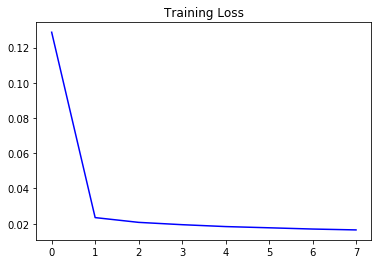

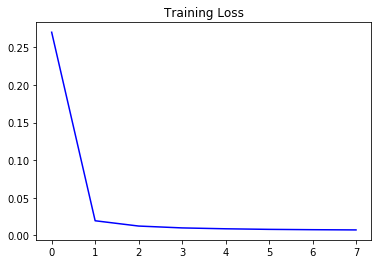

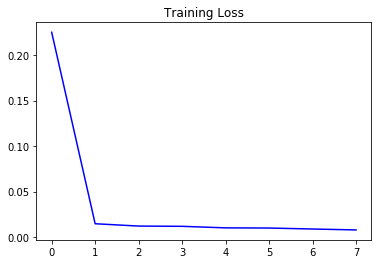

In [9]:
### VISUALIZATION ###
def training_plot(metrics):
    plt.figure(1)
    plt.plot([m.loss for m in metrics], 'b')
    plt.title('Training Loss')
    plt.show()

training_plot(sgd_trainer.metrics)
training_plot(adam_trainer.metrics)
training_plot(rms_trainer.metrics)

## Parameter Initialization

While training a network, the initial value of the weights plays a significant role. In the extreme case, an oracle could just set the weights directly to values that minimize the objective function, and in practical cases a good initialization can bring us to a more favorable starting position in the parameter space. 

This raises the question of how to choose these weights. 

- What happens if all the weights are set to zero? The gradients become zero, and the network finds itself without a direction. 
- What if all of them are set to the same non-zero value? Although the gradients are no longer zero, each neuron has the same weight and follows the same gradient. Such neurons will continue to have the same value, since they're identical. 

So any initialization scheme must break this symmetry somehow, and randomly initializing the weights is a first step in that direction.

Let's begin with creating a weight initialization function that samples from **N(0,1)**. A clean way of initializing the weights is to access the network parameters by traversing all modules inside the network, and then applying the desired initialization. This method also allows us to encapsulate all the initializations into a single function.

In [10]:
def init_randn(m):
    if type(m) == nn.Linear:
        m.weight.data.normal_(0,1)

Now let's use this scheme to initialize the network.

Note that *apply(fn)* applies the function *fn* recursively to every submodule (as returned by .children()) as well as self. Also, since it is applied to itself as well, I must take care to select the appropriate type of module *m* and apply the initialization to it.

In [11]:
normalmodel = FashionModel()
normalmodel.apply(init_randn)

FashionModel(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)

## Custom initializations

I should also choose a different way to initialize the weights, where you explicitly copy some values into the weights.

In [12]:
def init_custom(m):
    if type(m) == nn.Linear:
        rw = torch.randn(m.weight.data.size())
        m.weight.data.copy_(rw)

Now let's use this initialization scheme to implement Xavier initialization. 

Xavier initialization is a way of initializing the weights such that the variance of the inputs is the same as the variance of the outputs. At each layer, the fan_in and fan_out (i.e. input connections and output connections) might be different. To calculate the variance, you will multiply each weight with the inputs. Evidently, if the number of inputs is less, they will need to be multiplied with higher weights so that they can sum up to the product of a larger number of outputs with smaller weights. This is the intuition behind Xavier initialization.


In [13]:
def init_xavier(m):
    if type(m) == nn.Linear:
        fan_in = m.weight.size()[1]
        fan_out = m.weight.size()[0]
        std = np.sqrt(2.0 / (fan_in + fan_out))
        m.weight.data.normal_(0,std)

In [14]:
xaviermodel = FashionModel()
xaviermodel.apply(init_xavier)

FashionModel(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)

In [15]:
### LET'S TRAIN ###
n_epochs = 3

print("NORMAL INIT WEIGHTS")
AdamOptimizer = torch.optim.Adam(normalmodel.parameters(), lr=0.001)
normal_trainer = Trainer(normalmodel, AdamOptimizer)
normal_trainer.run(n_epochs)
normal_trainer.save_model('./normal_model.pt')
print('')


print("XAVIER INIT WEIGHTS")
AdamOptimizer = torch.optim.Adam(xaviermodel.parameters(), lr=0.001)
xavier_trainer = Trainer(xaviermodel, AdamOptimizer)
xavier_trainer.run(n_epochs)
xavier_trainer.save_model('./xavier_model.pt')
print('')

NORMAL INIT WEIGHTS
Start Training...


/anaconda3/envs/tf3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()
/anaconda3/envs/tf3/lib/python3.6/site-packages/ipykernel_launcher.py:43: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


epoch: 1, loss: 1.30572266
epoch: 2, loss: 0.41340820
epoch: 3, loss: 0.24266518

XAVIER INIT WEIGHTS
Start Training...
epoch: 1, loss: 0.00534021
epoch: 2, loss: 0.00380051
epoch: 3, loss: 0.00343334



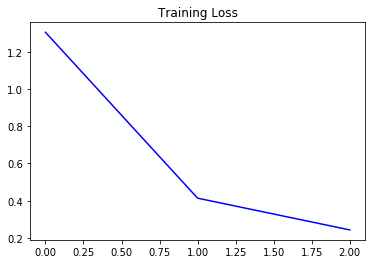

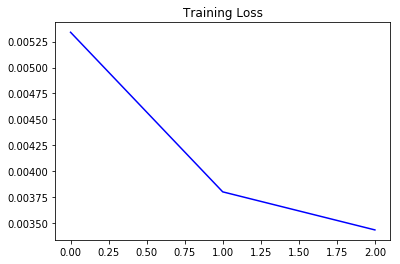

In [16]:
### VISUALIZATION ###
def training_plot(metrics):
    plt.figure(1)
    plt.plot([m.loss for m in metrics], 'b')
    plt.title('Training Loss')
    plt.show()

training_plot(normal_trainer.metrics)
training_plot(xavier_trainer.metrics)

## Using pretrained weights

In the previous section we saw that initializations can start the training from a good spot. In addition to these schemes, you might also need to have specific methods to initialize the weights in different layers. For example, you might want to use a pretrained model like Alexnet to give your network a head start for visual recognition tasks. Let's load the pretrained Alexnet model and see how it works.

In [17]:
alexnet_model = models.alexnet(pretrained=True)

## Adding Momentum

I shall make use of the `self.state` data-structure to maintain a copy of an accumulated gradient that we also decay at each step. Once again we use inplace operations to avoid unneccesary buffer allocation. Recall a standard update with momentum given decay rate $\mu$.

$$ \begin{align}
\textbf{V'} &= \mu \textbf{V} - \eta \nabla L(\textbf{W})\\
\textbf{W'} &= \textbf{W} + \textbf{V'}\\
\end{align}
$$

## Batch Normalization

Batch normalization is a relatively simple but significant improvement in training neural networks. In machine learning, *covariate shift* is a phenomenon in which the covariate distribution is non-stationary over the course of training. This is a common phenomenon in online learning. When training a neural network on a fixed dataset, there is no covariate shift (excluding sample noise from minibatch approximation), but the distribution of individual node and layer activity shifts as the network parameters are updated. As an abstraction, we can consider each node's activity to be a covariate of the following nodes in the network. Thus we can think of the non-stationarity of node (and layer) activations as a sort of *internal covariate shift*. 

Why is internal covariate shift a problem? Each subsequent layer has to account for a shifting distribution of its inputs. For saturating non-linearities the problem becomes even more dire, as the shift in activity will more likely place the unit output in the saturated region of the non-linearity.



In [ ]:
class BatchNorm(nn.Module):

    def __init__(self, num_features):
        super(BatchNorm, self).__init__()
        self.num_features = num_features
        self.affine = affine
        self.weight = Parameter(torch.Tensor(num_features))
        self.bias = Parameter(torch.Tensor(num_features))
        self.register_buffer('running_mean', torch.zeros(num_features))
        self.register_buffer('running_var', torch.ones(num_features))
        self.reset_parameters()

    def reset_parameters(self):
        self.running_mean.zero_()
        self.running_var.fill_(1)
        self.weight.data.uniform_()
        self.bias.data.zero_()

    def forward(self, x):
        pass

## Overfitting
Deep neural networks contain multiple non-linear hidden layers and this makes them very
expressive models that can learn very complicated relationships between their inputs and
outputs. With limited training data, however, many of these complicated relationships
will be the result of sampling noise, so they will exist in the training set but not in real
test data even if it is drawn from the same distribution. This leads to overfitting and many
methods have been developed for reducing it.

## Dropout
Dropout is a regularization technique for reducing overfitting in neural networks by preventing complex co-adaptations on training data. It is a very efficient way of performing model averaging with neural networks. The term "dropout" refers to dropping out units in a neural network.

## Regularization (weight_decay)

Weight decay specifies regularization in the neural network.
During training, a regularization term is added to the network's loss to compute the backpropagation gradient. The weight decay value determines how dominant this regularization term will be in the gradient computation.

As a rule of thumb, the more training examples you have, the weaker this term should be. The more parameters you have the higher this term should be.


In [18]:
class FashionModel_Tricks(nn.Module):
    
    def __init__(self):
        super(FashionModel_Tricks, self).__init__()
        self.fc1 = nn.Linear(784, 64)
        self.bnorm1 = nn.BatchNorm1d(64)
        self.dp1 = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(64, 32)
        self.bnorm2 = nn.BatchNorm1d(32)
        self.dp2 = nn.Dropout(p=0.1)
        self.fc3 = nn.Linear(32, 10)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dp1(self.bnorm1(x))
        x = F.relu(self.fc2(x))
        x = self.dp2(self.bnorm2(x))
        x = F.log_softmax(self.fc3(x))
        return x
print(FashionModel_Tricks())

FashionModel_Tricks(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (bnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.2)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (bnorm2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.1)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)


In [ ]:
### TRAIN MODELS WITH BATCHNORM AND DROPOUT ###
n_epochs = 10

model = FashionModel_Tricks()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9, weight_decay = 0.001)
btrainer = Trainer(model, optimizer)
btrainer.run(n_epochs)
btrainer.save_model('./dropout-batchnorm_optimized_model.pt')

training_plot(vtrainer.metrics)
training_plot(btrainer.metrics)

print('')

## Gradient Clipping

During experimentation, once the gradient value grows extremely large, it causes an overflow (i.e. NaN) which is easily detectable at runtime or in a less extreme situation, the Model starts overshooting past our Minima; this issue is called the Gradient Explosion Problem.

Gradient clipping will ‘clip’ the gradients or cap them to a Threshold value to prevent the gradients from getting too large.

In [ ]:
#Gradient Clipping 
# `clip_grad_norm` helps prevent the exploding gradient problem. To be used before optimizer.step()during training
torch.nn.utils.clip_grad_norm(model.parameters(), 0.25)

## Annealing Learning Rate
In training deep networks, it is usually helpful to anneal the learning rate over time. Good intuition to have in mind is that with a high learning rate, the system contains too much kinetic energy and the parameter vector bounces around chaotically, unable to settle down into deeper, but narrower parts of the loss function. Knowing when to decay the learning rate can be tricky: Decay it slowly and you’ll be wasting computation bouncing around chaotically with little improvement for a long time. But decay it too aggressively and the system will cool too quickly, unable to reach the best position it can. One way of doing it is using step decay. Step decay schedule drops the learning rate by a factor every few epochs. The mathematical form of step decay is:

$$\eta = \eta_0 * drop^{\floor ( \frac{epoch}{epochs\_drop})}$$

In [ ]:
def step_decay(epoch):
    initial_lrate = 0.1
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
    return lrate